In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# importing libraries/modules, and functions
import pandas as pd
import numpy as np
import scipy.stats as stats

# visualization libraries
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 200
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# math module for square root
from math import sqrt

# created zillow library and functions
from wrangle import get_zillow_dataset, clean_zillow_dataset, zillow_outliers, train_validate_test_split

# sklearn library for data science
import sklearn

# just in case :) 
import env
from env import user, password, host, get_connection

----
``1. Load your zillow dataset.``

``2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calfulatedfinishedsqft.``

In [2]:
# importing zillow dataset
zillow_df = get_zillow_dataset()
zillow_df = clean_zillow_dataset(zillow_df)
print(zillow_df.shape)
zillow_df.head()

(2140235, 7)


,bedroom_count,bath_count,finished_sq_feet,year_built,fips,tax_amount,home_value
4,4,2.0,3633.0,2005,6037,6941.39,296425.0
6,3,4.0,1620.0,2011,6037,10244.94,847770.0
7,3,2.0,2077.0,1926,6037,7924.68,646760.0
11,0,0.0,1200.0,1972,6037,91.60,5328.0
14,0,0.0,171.0,1973,6037,255.17,6920.0


In [3]:
# cleaning for outliers
zillow_df = zillow_outliers(zillow_df)
zillow_df.shape # checks out!

(2065188, 7)

In [4]:
# splitting the data into train, validate, and test
train, validate, test = train_validate_test_split(zillow_df)

print(f'trains shape: {train.shape}')
print(f'validate shape: {validate.shape}')
print(f'test shape: {test.shape}')

trains shape: (1156505, 7)
validate shape: (495645, 7)
test shape: (413038, 7)


In [5]:
# setting independent/dependent variables in ea. sub-dataset

X_train = train.drop(columns=["home_value", "tax_amount"])
y_train = train.home_value

X_validate = validate.drop(columns=["home_value", "tax_amount"])
y_validate = validate.home_value

X_test = test.drop(columns=["home_value", "tax_amount"])
y_test = test.home_value

In [6]:
# let's generate an average baseline prediction

baseline_predictions = round(train["home_value"].mean(), 2)
baseline_predictions

379821.82

----
**``Notes:``**

* baseline prediction mean represents the predicted house value average for all observations/records in the zillow train dataset

* we can now consider including this back in either our train or X_train or leave as is??

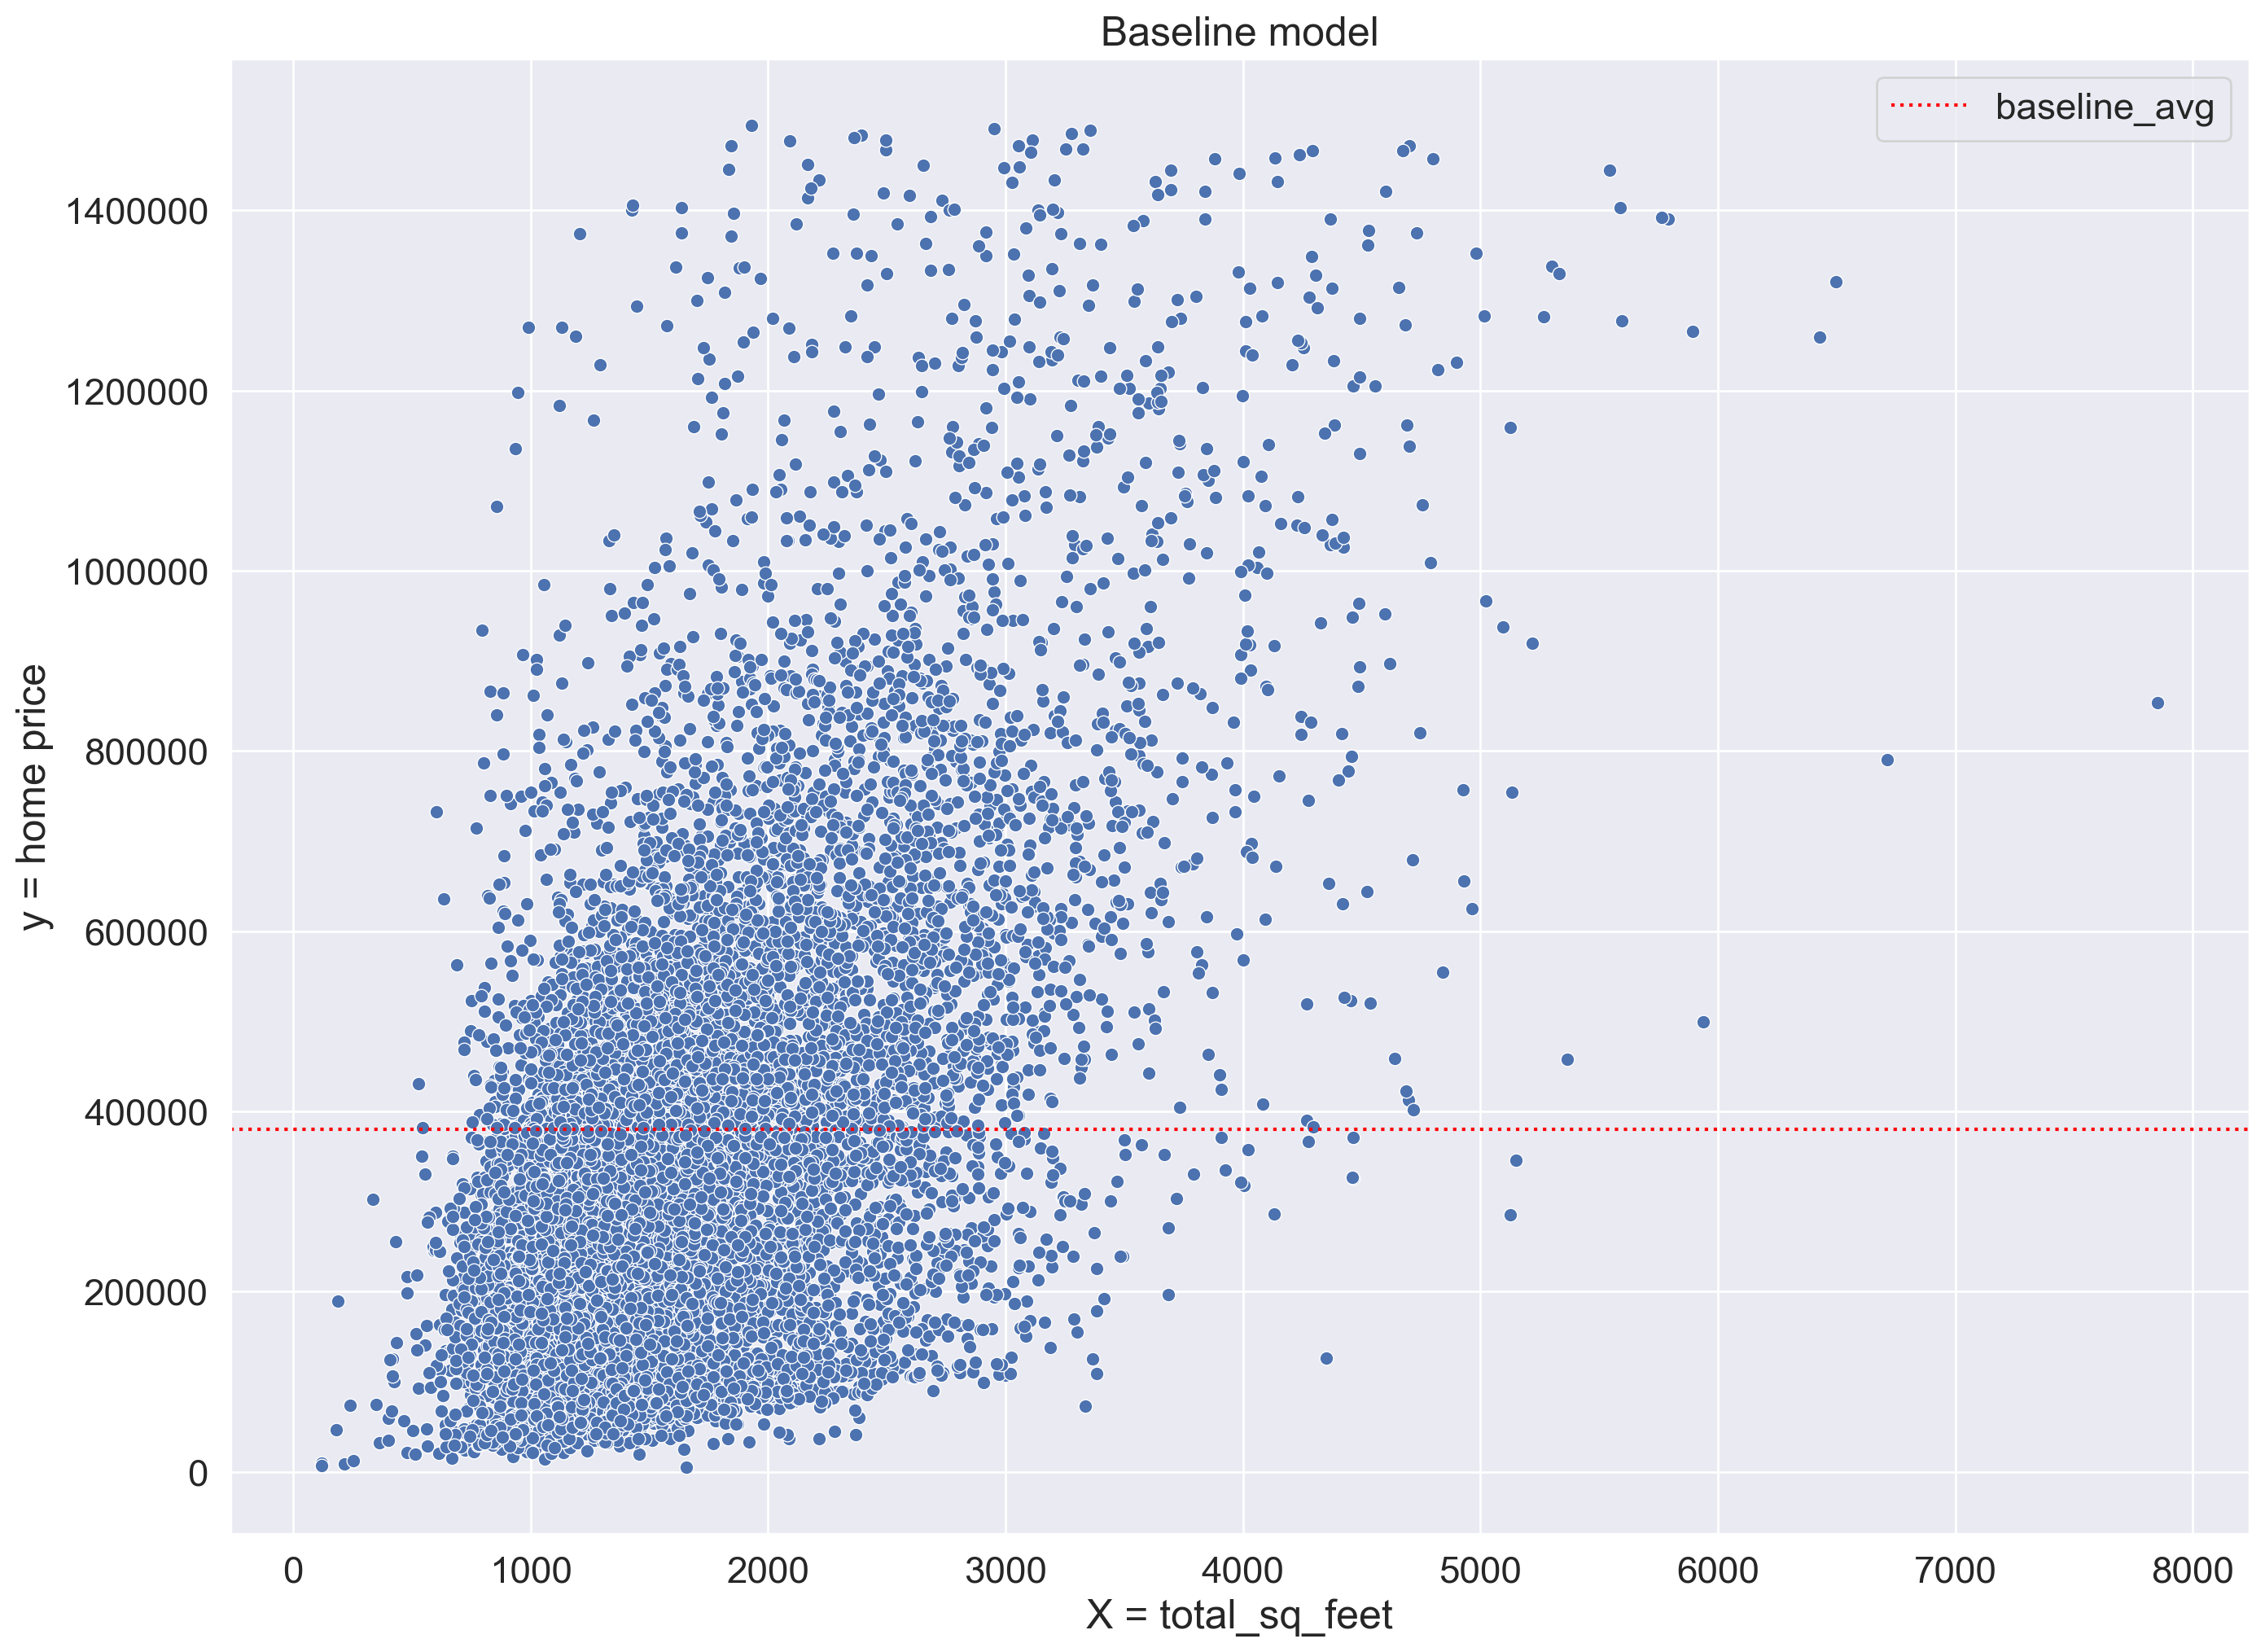

In [7]:
# let's plot the average baseline prediction home value against actual target values

plt.figure(figsize = (16, 12))
sns.set(font_scale = 1.5)

sns.scatterplot(x = "finished_sq_feet", y = "home_value", data = train.sample(10000, random_state = 123), x_jitter = 0.5)
plt.ticklabel_format(style = "plain") # removing axes scientific notation 

plt.axhline(baseline_predictions, ls = ':', color = "red", label = "baseline_avg")
plt.xlabel('X = total_sq_feet')
plt.ylabel('y = home price')

plt.legend()
plt.title('Baseline model')
plt.show()

----
``creating and fitting a new home_value predictive model``

In [8]:
from sklearn.linear_model import LinearRegression

# creating the independent and dependent variables
X_var = pd.DataFrame(train.finished_sq_feet)
y_var = pd.DataFrame(train.home_value)

In [9]:
# creating the model

model = LinearRegression(normalize = True)
model.fit(X_var, y_var)
predictions = model.predict(X_var)

In [10]:
# let's create a dataframe with all four (4) features:
# home_value (dependent variable)
# finished_sq_feet (independent variable)
# predicted avg. baseline home value
# created model predictions

df = pd.concat([X_var, y_var], axis = 1)
model_df = df.copy().reset_index(drop = True)

model_df["baseline"] = baseline_predictions

In [11]:
# including the "y_hat"/home value predictions
model_df["predictions"] = predictions.round(2)
model_df.head()

,finished_sq_feet,home_value,baseline,predictions
0,897.0,289346.0,379821.82,201678.54
1,1272.0,211722.0,379821.82,277987.35
2,666.0,36500.0,379821.82,154672.31
3,3246.0,900549.0,379821.82,679676.92
4,1870.0,769000.0,379821.82,399674.46


----
``3. Plot the residuals for the linear regression model that you made.``

In [12]:
# plotting the baseline residual error (actual - baseline prediction)
model_df["baseline_residuals"] = model_df["home_value"] - model_df["baseline"]
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals
0,897.0,289346.0,379821.82,201678.54,-90475.82
1,1272.0,211722.0,379821.82,277987.35,-168099.82
2,666.0,36500.0,379821.82,154672.31,-343321.82
3,3246.0,900549.0,379821.82,679676.92,520727.18
4,1870.0,769000.0,379821.82,399674.46,389178.18


In [13]:
model_df["residuals"] = model_df["home_value"] - model_df["predictions"]
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals,residuals
0,897.0,289346.0,379821.82,201678.54,-90475.82,87667.46
1,1272.0,211722.0,379821.82,277987.35,-168099.82,-66265.35
2,666.0,36500.0,379821.82,154672.31,-343321.82,-118172.31
3,3246.0,900549.0,379821.82,679676.92,520727.18,220872.08
4,1870.0,769000.0,379821.82,399674.46,389178.18,369325.54


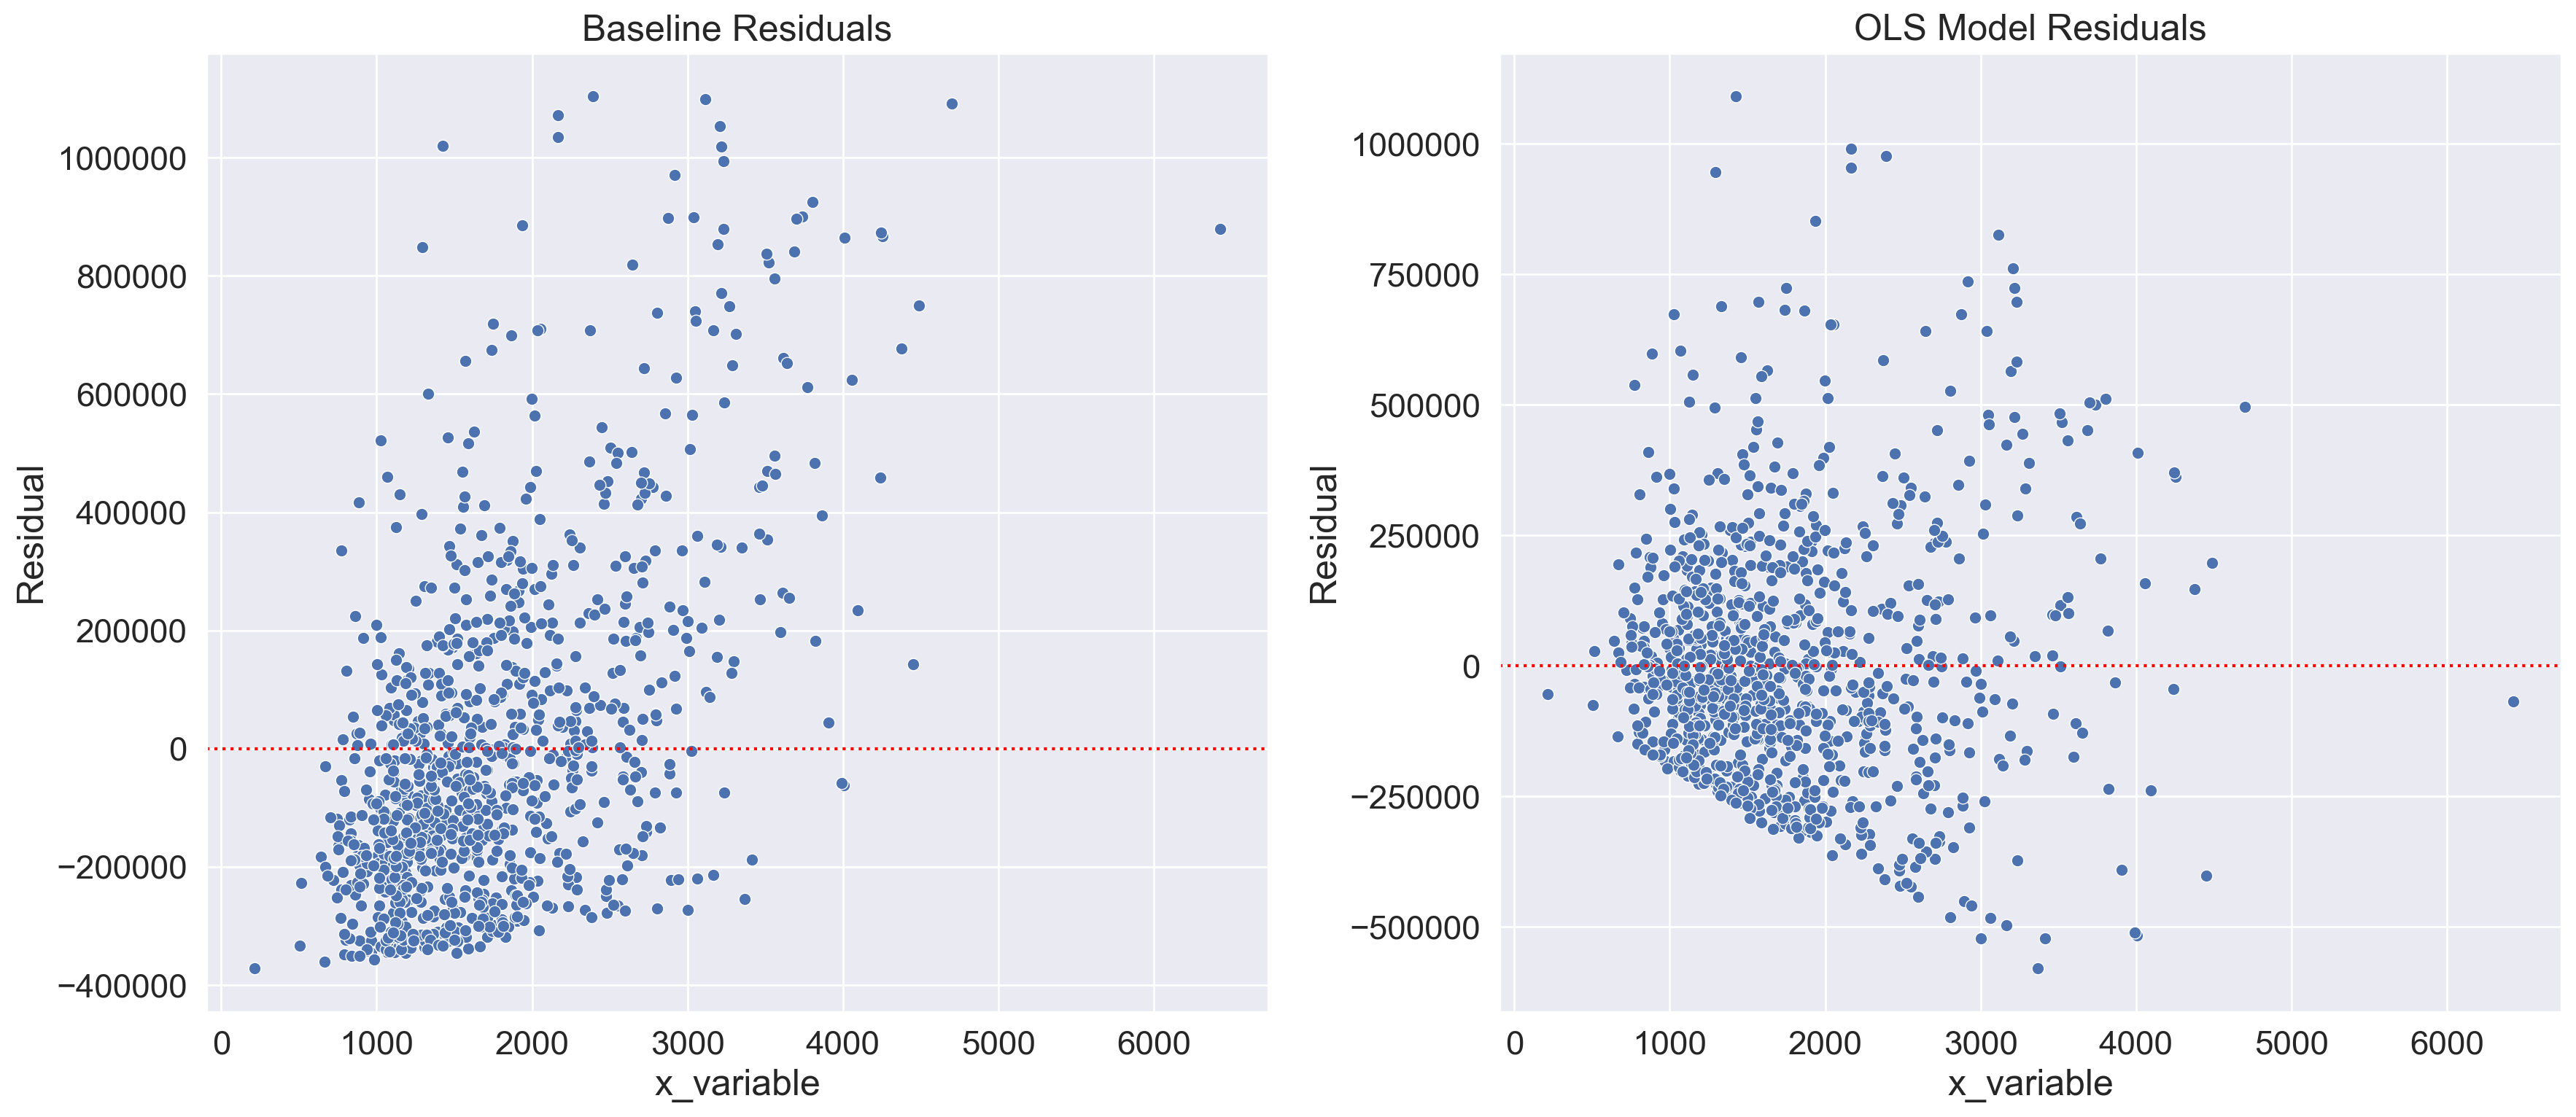

In [14]:
# considering creating a function that creates these plots

plt.figure(figsize = (12,6))

plt.subplot(121)
ax = sns.scatterplot(x = "finished_sq_feet", y = "baseline_residuals", data = model_df.sample(1000, random_state = 123))
plt.axhline(y = 0, ls = ':', color = "red")
plt.xlabel('x_variable')
plt.ylabel('Residual')
plt.title('Baseline Residuals')
 # removing axes scientific notation
plt.ticklabel_format(style = "plain")

# making individual plots more readable
ax.figure.set_size_inches(18, 6)

plt.subplot(122)
ax = sns.scatterplot(x = "finished_sq_feet", y = "residuals", data = model_df.sample(1000, random_state = 123))
plt.axhline(y = 0, ls = ':', color = "red")

plt.xlabel('x_variable')
plt.ylabel('Residual')
plt.title('OLS Model Residuals')
# removing axes scientific notation
plt.ticklabel_format(style = "plain") 

# making individual plots more readable
ax.figure.set_size_inches(18, 8)
plt.tight_layout()

----
``4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.``

In [15]:
# calculating the Sum of Squared Errors "SSE" or "Residual Sum of Squares"/RSS for my model
# where the Sum of Squared Errors or Residual Sum of Squares refers to the total "dispersion" of the individual data point error
# this measurement can determine how well or not the created model represents the "actual" target data

model_df["residual^2"] = model_df["residuals"].round(2) ** 2
model_df["baseline_residual^2"] = model_df["baseline_residuals"].round(2) ** 2
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals,residuals,residual^2,baseline_residual^2
0,897.0,289346.0,379821.82,201678.54,-90475.82,87667.46,7.685584e+09,8.185874e+09
1,1272.0,211722.0,379821.82,277987.35,-168099.82,-66265.35,4.391097e+09,2.825755e+10
2,666.0,36500.0,379821.82,154672.31,-343321.82,-118172.31,1.396469e+10,1.178699e+11
3,3246.0,900549.0,379821.82,679676.92,520727.18,220872.08,4.878448e+10,2.711568e+11
4,1870.0,769000.0,379821.82,399674.46,389178.18,369325.54,1.364014e+11,1.514597e+11


In [16]:
# calculating sum of squared error

SSE_model = sum(model_df["residual^2"])
print('(Model) SSE = {:.1f}'.format(SSE_model))

(Model) SSE = 59231036999123528.0


**``Source: "statisticshowto.com"``**


![sum_of_squares](https://www.statisticshowto.com/wp-content/uploads/2015/04/sum-of-squares.jpg)

In [17]:
# calculating the explained sum of squares or "ESS"
# explained error
# The ESS (Explained Sum of Squares) is the sum of the difference between each predicted value (y_hat = home_price prediction) and the mean of all actual values (y.mean = home_value mean)

ESS_model = sum((model_df["predictions"] - model_df["home_value"].mean()) ** 2)
print('(Model) Explained Sum of Squares = {:.1f}'.format(ESS_model))

(Model) Explained Sum of Squares = 26816100128124708.0


In [18]:
# calculating the total sum of squares errors or "TSS"
# The TSS (Total Sum of Squares) is the sum of difference between the actual final grade and the mean of all final grades
# It can also be derived by summing the ESS and SSE

TSS_model = ESS_model + SSE_model
print('(Model) Total Sum of Squares = {:.1f}'.format(TSS_model))

(Model) Total Sum of Squares = 86047137127248240.0


In [19]:
# calculating mean squared error or MSE
# we arrive at this by dividing your SSE by the total number of data points
# i.e. the average of your errors that have each been squared

MSE_model = SSE_model/len(model_df)
print('(Model) Mean Squared Error = {:.1f}'.format(MSE_model))

(Model) Mean Squared Error = 51215547705.5


In [20]:
# calculating the root mean squared error or RMSE

RMSE_model = sqrt(MSE_model)
print('(Model) Root Mean Squared Error = {:.1f}'.format(RMSE_model))

(Model) Root Mean Squared Error = 226308.5


----
``5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount / or "baseline_predictions).``

In [21]:
# calculating sum of squared error

SSE_baseline = sum(model_df["baseline_residual^2"])
print('(Baseline) SSE = {:.1f}'.format(SSE_baseline))

(Baseline) SSE = 86047137119505616.0


In [22]:
# calculating the explained sum of squares or "ESS"
# explained error
# The ESS (Explained Sum of Squares) is the sum of the difference between each predicted value (y_hat = home_price prediction) and the mean of all actual values (y.mean = home_value mean)

ESS_baseline = sum((model_df["baseline"] - model_df["home_value"].mean()) ** 2)
print('(Baseline) Explained Sum of Squares = {:.1f}'.format(ESS_baseline))

(Baseline) Explained Sum of Squares = 14.3


In [23]:
# calculating the total sum of squares errors or "TSS"
# The TSS (Total Sum of Squares) is the sum of difference between the actual final grade and the mean of all final grades
# It can also be derived by summing the ESS and SSE

TSS_baseline = ESS_baseline + SSE_baseline
print('(Baseline) Total Sum of Squares = {:.1f}'.format(TSS_baseline))

(Baseline) Total Sum of Squares = 86047137119505632.0


In [24]:
# calculating mean squared error or MSE
# we arrive at this by dividing your SSE by the total number of data points
# i.e. the average of your errors that have each been squared

MSE_baseline = SSE_baseline/len(model_df)
print('(Baseline) Mean Squared Error = {:.1f}'.format(MSE_baseline))

(Baseline) Mean Squared Error = 74402736797.1


In [25]:
# calculating the root mean squared error or RMSE

RMSE_baseline = sqrt(MSE_baseline)
print('(Baseline) Root Mean Squared Error = {:.1f}'.format(RMSE_baseline))

(Baseline) Root Mean Squared Error = 272768.7


----
``6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.``

In [26]:
def compare_sum_of_squares(SSE_baseline, SSE_model):
    if SSE_model >= SSE_baseline:
        print("Model DOES NOT outperform baseline.")
    else:
        print("Model outperforms baseline!")

----
``7. What is the amount of variance explained in your model?``

In [27]:
# calculating model variance
# where variance == R^2 or "coefficient of determination" (a measurement from 0 to 1)
# R2: variance in y (target) explained by X (predictor); closer to 1 is better

model_variance = ESS_model/TSS_model
print('Model Variance = {:.1f}'.format(model_variance))

Model Variance = 0.3


In [28]:
# calculating the baseline variance

baseline_variance = ESS_baseline/TSS_baseline
print('Baseline Variance = {:.1f}'.format(baseline_variance))

Baseline Variance = 0.0


In [29]:
# let's use sklearn to calculate model variance

model_var = sklearn.metrics.explained_variance_score(model_df["home_value"], model_df["predictions"])
model_var.round(3) # checks out!

0.312

In [30]:
# let's use sklearn to calculate baseline variance

baseline_var = sklearn.metrics.explained_variance_score(model_df["home_value"], model_df["baseline"])
baseline_var.round(3) # checks out!

0.0

----
``8. Is your model better than the baseline model?``

Yes, my model is ~30% more accurate than baseline predictions.

----
``9. Create a file named evaluate.py that contains the following functions.``

- [ ] ``plot_residuals(y, yhat):`` creates a residual plot
- [ ] ``regression_errors(y, yhat):`` returns the following values:
- [ ] sum of squared errors (SSE)
- [ ] explained sum of squares (ESS)
- [ ] total sum of squares (TSS)
- [ ] mean squared error (MSE)
- [ ] root mean squared error (RMSE)

In [31]:
# creating the "plot_residuals" function which will be added to my wrangle/prepare file

def plot_residuals(y, y_hat):
    y = y.sample(5000, random_state = 123)
    y_hat = y_hat.sample(5000, random_state = 123)
    residuals = y - y_hat
    plt.figure(figsize = (12,6))
    ax = plt.scatter(x = y, y = residuals, 
                alpha = 1/5)

    plt.axhline(y = 0, ls = ':', color = "red", linewidth = 2)
    plt.xlabel('y_variable')
    plt.ylabel('Residual')
    plt.title('Model Residuals')
    # removing axes scientific notation
    plt.ticklabel_format(style = "plain") 

    # making individual plots more readable
    ax.figure.set_size_inches(18, 8)

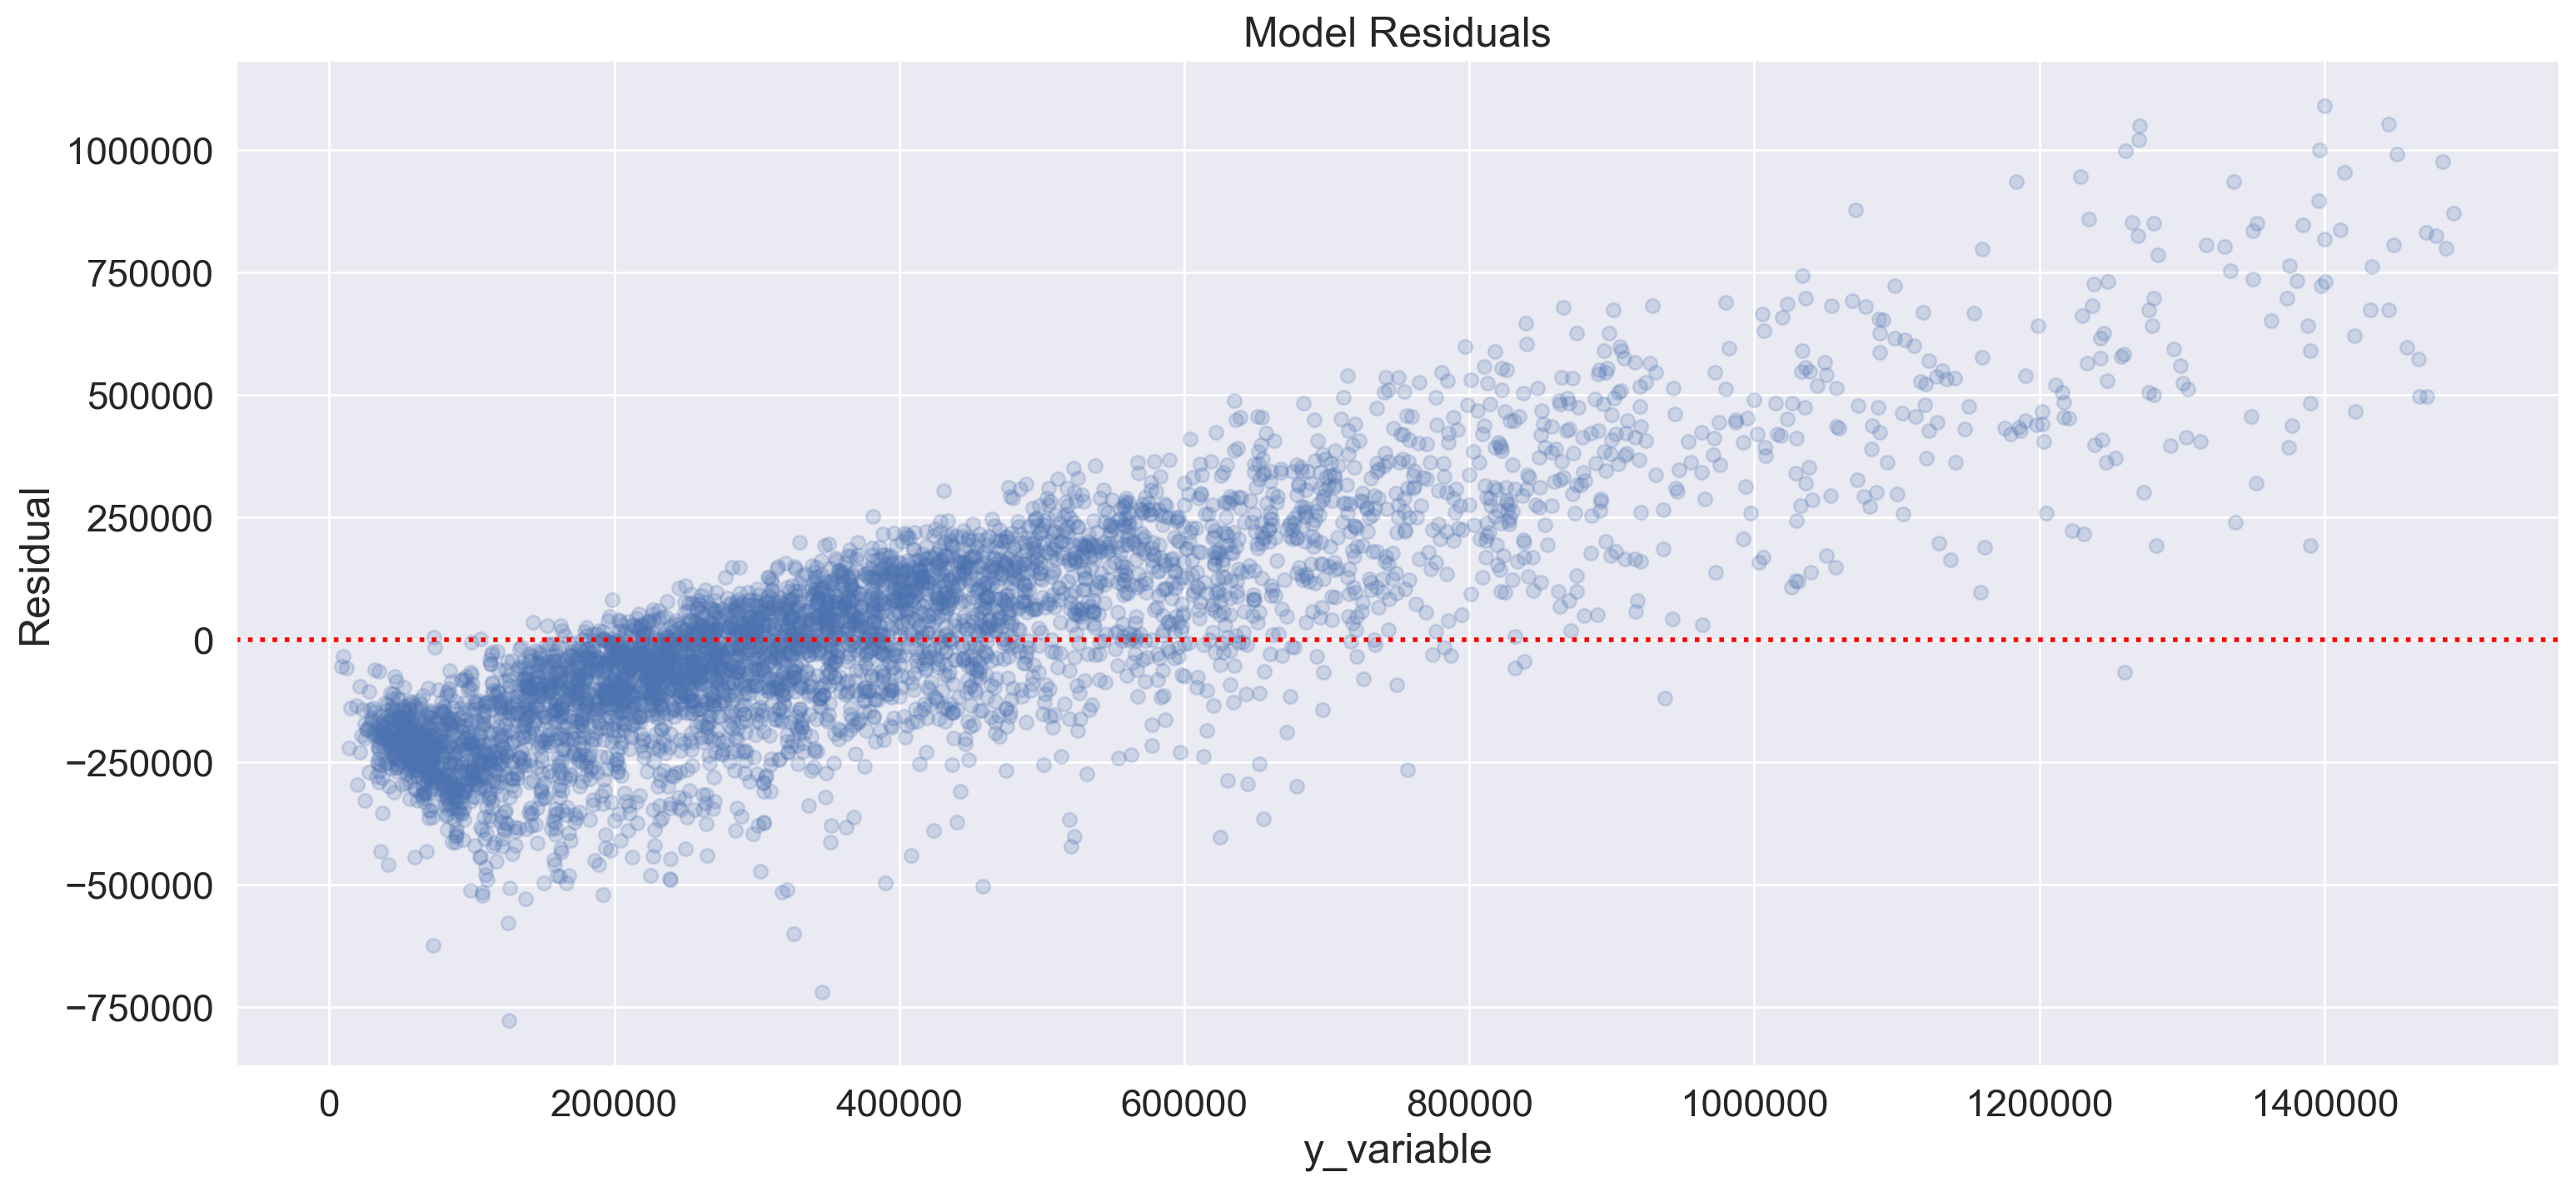

In [32]:
plot_residuals(model_df["home_value"], model_df["predictions"])

In [33]:
# creating the regressions error function

def regression_errors(y, y_hat):
    # importing math.sqrt module for calculations
    from math import sqrt
    
    # generating model residuals and residuals squared
    df = y.sample(1000, random_state = 123) - y_hat.sample(1000, random_state = 123)
    df["residual^2"] = df.round(2) ** 2

    # generating sum of squared error
    SSE = sum(df["residual^2"])

    # generating explained sum of squares
    ESS = sum((y_hat - y.mean()) ** 2)

    # generating total sum of squares error
    TSS = ESS + SSE

    # generating mean squared error
    MSE = SSE/len(y)

    # generating root mean squared error
    RMSE = sqrt(MSE)

    return SSE, ESS, TSS, MSE, RMSE

In [34]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(model_df["home_value"], model_df["predictions"])

print('SSE = {:.1f}'.format(SSE))
print('ESS = {:.1f}'.format(ESS))
print('TSS = {:.1f}'.format(TSS))
print('MSE = {:.1f}'.format(MSE))
print('RMSE = {:.1f}'.format(RMSE))

SSE = 54532439506523.6
ESS = 26816100128124708.0
TSS = 26870632567631232.0
MSE = 47152791.8
RMSE = 6866.8


----
``Create the following functions:``
* baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
* better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false

In [35]:
# in order to not confuse/minimize the number of created functions (which do the same action), i will use my "regression_errors" function for both predicted and baseline errors
# let's create the "better_than_baseline" function and add this to my wrangle/prepare file

def better_than_baseline(y, y_hat):
    df_model = y.sample(1000, random_state = 123) - y_hat.sample(1000, random_state = 123)
    df_model["residual^2"] = df_model.round(2) ** 2

    # calculating a baseline
    baseline = round(y.sample(1000, random_state = 123).mean(), 2)

    # creating an empty DataFrame with n_rows as y
    df = pd.DataFrame(index = range(len(y)))

    # setting the n_values for all indices in df
    df["baseline"] = baseline

    df["baseline_residuals"] = y - df["baseline"]
    df["baseline_residual^2"] = df["baseline_residuals"].round(2) ** 2

    # generating sum of squared error
    SSE_model = sum(df_model["residual^2"])
    SSE_baseline = sum(df["baseline_residual^2"])


    if SSE_model < SSE_baseline:
        return True
    else:
        return False
    

In [36]:
better_than_baseline(model_df["home_value"], model_df["predictions"])

True